<a href="https://colab.research.google.com/github/marieangeboum/rs-segsem-dil/blob/master/image_notebook/sam_bbox_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Part of this code utilizes the `segment-geospatial` package, which is a Python package designed for segmenting geospatial data using the Segment Anything Model (SAM). This package was created by Professor Dr. Qiusheng Wu.

The `segment-geospatial` package has been adapted from the `segment-anything-eo` repository, originally authored by Aliaksandr Hancharenka. The main goal of the `segment-geospatial` package is to simplify the process of applying SAM to geospatial data analysis, making it more accessible and requiring minimal coding effort.

To use this package, it's available for download and installation via PyPI and conda-forge.

For more information, details, and examples on how to use this package, you can visit Professor Wu's GitHub page at [https://github.com/opengeos/segment-geospatial](https://github.com/opengeos/segment-geospatial).

In [1]:
# Install the necessary libraries
!pip install pycrs segment-geospatial leafmap localtileserver

In [2]:
# Import required libraries
import os
import cv2
import torch
import zipfile
#import leafmap
import geopandas as gpd
import numpy as np
import rasterio
import glob
from rasterio.merge import merge
from rasterio.features import shapes
from shapely.geometry import shape

from segment_anything import SamPredictor
from samgeo import SamGeo, SamGeoPredictor, tms_to_geotiff
from segment_anything import sam_model_registry
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
def read_shapefile(filepath):
    """
    Reads a shapefile and extracts bounding boxes.

    Parameters:
        filepath (str): Path to the shapefile.

    Returns:
        List of bounding boxes.
    """
    gdf = gpd.read_file(filepath)
    condition = gdf['class'] != 0.0
    gdf = gdf[condition]
    return [list(geom.bounds) for geom in gdf.geometry]

def initialize_predictor(img_arr, checkpoint):
    """
    Initializes SamGeoPredictor.

    Parameters:
        img_arr (np.array): Image array.
        checkpoint (str): Path to the model checkpoint.

    Returns:
        An instance of SamGeoPredictor.
    """
    model_type = "vit_h"
    sam = sam_model_registry[model_type](checkpoint=checkpoint)
    predictor = SamGeoPredictor(sam)
    predictor.set_image(img_arr)

    return predictor
def process_clip_boxes(image, clip_boxes, predictor):
    """
    Processes each clip box, creates geojson files, and adds them to the map.

    Parameters:
        image (str): Image file path.
        clip_boxes (list): List of bounding boxes.
        predictor (SamGeoPredictor): An instance of SamGeoPredictor.

    Returns:
        None
    """
    combined_gdf = gpd.GeoDataFrame()

    src_files_to_mosaic = []

    for i, clip_box in enumerate(clip_boxes):
        print(f"Processing clip box {i+1}/{len(clip_boxes)}")
        print(clip_box)
        masks, _, _ = predictor.predict(src_fp=image, geo_box=clip_box)

        # Ensure masks are binary
        masks = (masks > 0).astype('uint8')

        masks_img = f"preds_{i}.tif"
        predictor.masks_to_geotiff(image, masks_img, masks)

        src = rasterio.open(masks_img)
        src_files_to_mosaic.append(src)

        vector = f"feats_{i}.geojson"
        temp_gdf = predictor.geotiff_to_geojson(masks_img, vector, bidx=1)
        combined_gdf = combined_gdf.append(temp_gdf)
        combined_gdf.set_geometry('geometry', inplace=True)

    # Mosaic and write the mosaic raster to disk
    mosaic, out_trans = merge(src_files_to_mosaic)
    out_meta = src.meta.copy()

    out_meta.update({"driver": "GTiff",
                    "dtype": 'uint8',
                    "height": mosaic.shape[1],
                    "width": mosaic.shape[2],
                    "count": 1,
                    "transform": out_trans,
                    "crs": src.crs})

    with rasterio.open('mosaic_mask.tif', "w", **out_meta) as dest:
        dest.write(mosaic[0], 1)

    # Save polygons as separate features in a shapefile
    combined_gdf['geometry'] = combined_gdf.geometry.buffer(0)
    combined_gdf.to_file("separate_features.shp")

def show_mask(mask, ax, random_color=False):
  if random_color:
    color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
  else:
    color = np.array([30/255, 144/255, 255/255, 0.6])
  h, w = mask.shape[-2:]
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
  ax.imshow(mask_image)



def read_image_and_mask(image_path, mask_path):
    """
    Lit l'image et le masque de segmentation à partir des chemins spécifiés en utilisant rasterio.

    Args:
    - image_path (str): Chemin vers l'image.
    - mask_path (str): Chemin vers le masque de segmentation.

    Returns:
    - image (np.ndarray): L'image chargée.
    - mask (np.ndarray): Le masque de segmentation chargé.
    """
    with rasterio.open(image_path) as src_image:
        image = src_image.read([1, 2, 3])  # Lire les trois premières bandes (par exemple, RGB)

    with rasterio.open(mask_path) as src_mask:
        mask = src_mask.read(1)  # Lire la première bande

    return image, mask

def plot_image_with_mask(image, mask):
    """
    Affiche l'image avec le masque de segmentation superposé.

    Args:
    - image (np.ndarray): L'image chargée.
    - mask (np.ndarray): Le masque de segmentation chargé.
    """
    # Transposer l'image pour correspondre aux dimensions matplotlib (H, W, C)
    image = np.transpose(image, (1, 2, 0))

    # Créer une figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Afficher l'image
    ax.imshow(image)

    # Superposer le masque avec alpha pour la transparence
    ax.imshow(mask, cmap='jet', alpha=0.5)

    # Supprimer les axes
    ax.axis('off')

    # Afficher la figure
    plt.show()

In [4]:
# Switch to your image and shapefile instead
image = '/content/images/accra_3.tif'
shapefile = '/content/labels/bbox_accra_3.shp'
mask = '/content/labels/accra_3.tif'

In [5]:
sam = SamGeo(
    model_type="vit_h",
    checkpoint="/root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth",
    sam_kwargs=None,
)


In [6]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint="/root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth")
sam.to(device=DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [7]:
clip_boxes = read_shapefile(shapefile)

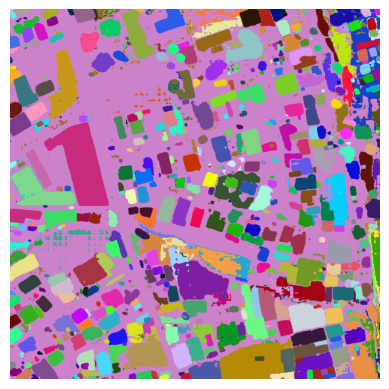

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_mask_on_image(image, mask, color):
    """Apply the mask to the image with the given color."""
    for c in range(3):
        image[:, :, c] = np.where(mask == 1, color[c] * 255, image[:, :, c])
    return image

# Lire l'image
img_arr = cv2.imread(image)
mask_predictor = SamPredictor(sam)
mask_predictor.set_image(img_arr)

# Copier l'image de base pour afficher les masques
img_with_masks = img_arr.copy()

# Traiter chaque boîte dans clip_boxes
for clip_box in clip_boxes:
    # Convertir la boîte en tableau numpy et s'assurer qu'elle est de type entier
    clip_box = np.array(clip_box).astype(int)

    # Prédire les masques, scores et logits pour la boîte actuelle
    masks, scores, logits = mask_predictor.predict(
        box=clip_box,
        multimask_output=True
    )

    # Appliquer chaque masque sur l'image de base
    for mask in masks:
        color = np.random.rand(3)  # Couleur aléatoire pour chaque masque
        img_with_masks = show_mask_on_image(img_with_masks, mask, color)

# Fusionner img_with_masks avec l'image d'origine
alpha = 0.5  # Facteur de transparence
blended_image = cv2.addWeighted(img_arr, 1 - alpha, img_with_masks, alpha, 0)

# Afficher l'image fusionnée
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

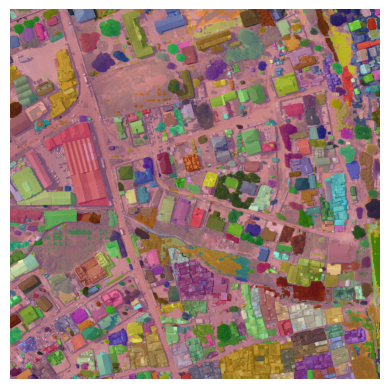

In [14]:
# Fusionner img_with_masks avec l'image d'origine
alpha = 0.5  # Facteur de transparence
blended_image = cv2.addWeighted(img_arr, 1 - alpha, img_with_masks, alpha, 0)

# Afficher l'image fusionnée
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [19]:
import geopandas as gpd

def read_shapefile(filepath):
    """
    Reads a shapefile and extracts bounding boxes and their associated classes.

    Parameters:
        filepath (str): Path to the shapefile.

    Returns:
        List of tuples, each containing a bounding box and the associated class.
    """
    gdf = gpd.read_file(filepath)
    condition = gdf['class'] != 0.0
    gdf = gdf[condition]

    # Extraire les boîtes englobantes et les classes associées
    boxes_and_classes = [(list(geom.bounds), cls) for geom, cls in zip(gdf.geometry, gdf['class'])]

    return boxes_and_classes

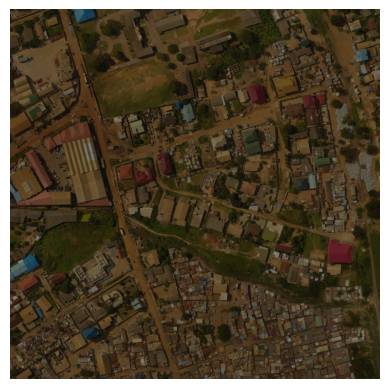

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

cmap = plt.get_cmap('tab10')
class_colors = {i+1: cmap(i)[:3] for i in range(8)}

def show_mask_on_image(image, mask, color):
    """Apply the mask to the image with the given color."""
    for c in range(3):
        image[:, :, c] = np.where(mask == 1, color[c], image[:, :, c])
    return image

# Lire l'image
img_arr = cv2.imread(image)
mask_predictor = SamPredictor(sam)
mask_predictor.set_image(img_arr)

# Copier l'image de base pour afficher les masques
img_with_masks = np.zeros_like(img_arr)

# Lire les boîtes et les classes du shapefile
boxes_and_classes = read_shapefile(shapefile)

# Traiter chaque boîte avec la classe associée
for clip_box, cls in boxes_and_classes:
    # Convertir la boîte en tableau numpy et s'assurer qu'elle est de type entier
    clip_box = np.array(clip_box).astype(int)

    # Prédire les masques, scores et logits pour la boîte actuelle
    masks, scores, logits = mask_predictor.predict(
        box=clip_box,
        multimask_output=True
    )

    # Couleur associée à la classe
    color = class_colors.get(cls, [255, 255, 255])  # Blanc par défaut si classe non trouvée

    # Appliquer chaque masque sur l'image de base
    for mask in masks:
        img_with_masks = show_mask_on_image(img_with_masks, mask, color)

# Fusionner img_with_masks avec l'image d'origine
alpha = 0.5  # Facteur de transparence
blended_image = cv2.addWeighted(img_arr, 1 - alpha, img_with_masks, alpha, 0)

# Afficher l'image fusionnée
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


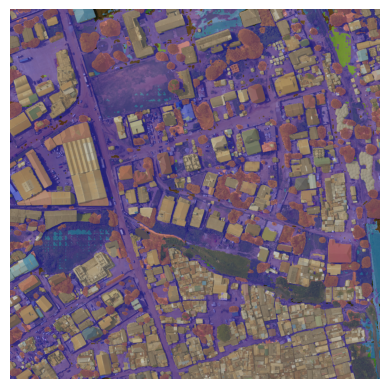

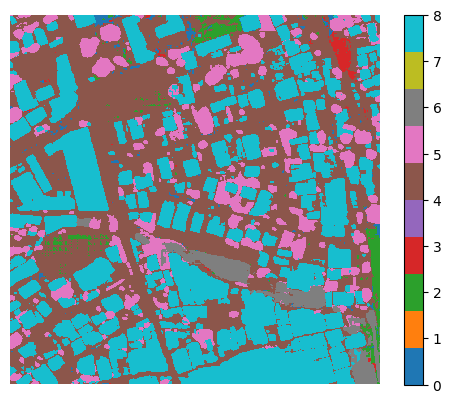

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

def show_mask_on_image(image, mask, color):
    """Apply the mask to the image with the given color."""
    for c in range(3):
        image[:, :, c] = np.where(mask == 1, color[c], image[:, :, c])
    return image

def read_shapefile(filepath):
    """
    Reads a shapefile and extracts bounding boxes and their associated classes.

    Parameters:
        filepath (str): Path to the shapefile.

    Returns:
        List of tuples, each containing a bounding box and the associated class.
    """
    gdf = gpd.read_file(filepath)
    condition = gdf['class'] != 0.0
    gdf = gdf[condition]

    # Extraire les boîtes englobantes et les classes associées
    boxes_and_classes = [(list(geom.bounds), cls) for geom, cls in zip(gdf.geometry, gdf['class'])]

    return boxes_and_classes

# Lire l'image
image_path = 'mask.jpg'
img_arr = cv2.imread(image)
mask_predictor = SamPredictor(sam)
mask_predictor.set_image(img_arr)

# Copier l'image de base pour afficher les masques
img_with_masks = np.zeros_like(img_arr)

# Initialiser le masque de segmentation final
segmentation_mask = np.zeros((img_arr.shape[0], img_arr.shape[1]), dtype=np.uint8)

# Lire les boîtes et les classes du shapefile

boxes_and_classes = read_shapefile(shapefile)

# Définir les couleurs pour chaque classe en utilisant la colormap tab10
cmap = plt.get_cmap('tab10')
class_colors = {i+1: cmap(i)[:3] for i in range(8)}  # tab10 has 10 distinct colors

# Traiter chaque boîte avec la classe associée
for clip_box, cls in boxes_and_classes:
    # Convertir la boîte en tableau numpy et s'assurer qu'elle est de type entier
    clip_box = np.array(clip_box).astype(int)

    # Prédire les masques, scores et logits pour la boîte actuelle
    masks, scores, logits = mask_predictor.predict(
        box=clip_box,
        multimask_output=True
    )

    # Couleur associée à la classe
    color = (np.array(class_colors[cls]) * 255).astype(int)  # Convertir en 0-255

    # Appliquer chaque masque sur l'image de base
    for mask in masks:
        img_with_masks = show_mask_on_image(img_with_masks, mask, color)

        # Mettre à jour le masque de segmentation final
        segmentation_mask = np.where(mask == 1, cls, segmentation_mask)

# Fusionner img_with_masks avec l'image d'origine
alpha = 0.5  # Facteur de transparence
blended_image = cv2.addWeighted(img_arr, 1 - alpha, img_with_masks, alpha, 0)

# Afficher l'image fusionnée
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Afficher le masque de segmentation final
plt.imshow(segmentation_mask, cmap='tab10', interpolation='none')
plt.colorbar()
plt.axis('off')
plt.show()

# Le masque de segmentation final est dans la variable segmentation_mask


In [25]:
import numpy as np
import rasterio
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt

def read_tif_mask(filepath):
    """
    Reads a TIFF mask and returns it as a numpy array.

    Parameters:
        filepath (str): Path to the TIFF mask file.

    Returns:
        numpy array: Mask array.
    """
    with rasterio.open(filepath) as src:
        mask = src.read(1)  # Lire la première bande du fichier TIFF
    return mask

def compute_iou(pred_mask, true_mask, num_classes):
    """
    Computes the Intersection over Union (IoU) for each class.

    Parameters:
        pred_mask (numpy array): Predicted segmentation mask.
        true_mask (numpy array): Ground truth mask.
        num_classes (int): Number of classes.

    Returns:
        dict: Dictionary with class indices as keys and IoU values as values.
    """
    iou_scores = {}
    for cls in range(1, num_classes + 1):
        # Calculer les zones d'intersection et d'union
        pred_mask_cls = (pred_mask == cls).astype(np.uint8)
        true_mask_cls = (true_mask == cls).astype(np.uint8)

        intersection = np.sum((pred_mask_cls == 1) & (true_mask_cls == 1))
        union = np.sum((pred_mask_cls == 1) | (true_mask_cls == 1))

        # Calculer l'IoU
        iou = intersection / union if union != 0 else 0
        iou_scores[cls] = iou

    return iou_scores

# Lire les masques
segmentation_mask = np.array(segmentation_mask)  # Votre masque de segmentation
truth_mask = read_tif_mask('/content/labels/accra_3.tif')  # Masque de vérité terrain

# Nombre de classes
num_classes = 8

# Calculer l'IoU
iou_scores = compute_iou(segmentation_mask, truth_mask, num_classes)

# Afficher les scores IoU
for cls, iou in iou_scores.items():
    print(f"Class {cls}: IoU = {iou:.4f}")


Class 1: IoU = 0.0000
Class 2: IoU = 0.0695
Class 3: IoU = 0.0139
Class 4: IoU = 0.2101
Class 5: IoU = 0.6109
Class 6: IoU = 0.1396
Class 7: IoU = 0.0000
Class 8: IoU = 0.7407
